# Распознавание символов при помощи нейронных сетей

Упражнение из Kaggle:
https://www.kaggle.com/competitions/digit-recognizer/data

Цель - предсказать показанное на изображении число

In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1.Импорт данных

Импортируем данные, смотрим на них.

Данные представляют собой лэйбл (то есть число на изображении), и изображение 28 * 28 пикселей. Для каждого пикселя из 28 * 28 = 784 представлена его глубина, то есть оттенок от 0 до 255. Изображение одноканальное, т.е. чернобелое. 

In [2]:
df = pd.read_csv('Digit Recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


В качестве обработки отделяем входные и выходные данные, то есть лэйбл это Y, изображение - X

In [3]:
X = df.drop('label',axis=1)
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y = df['label']
Y.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

Смотрим, что представляют из себя изображения

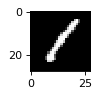

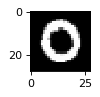

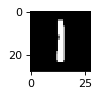

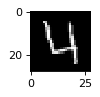

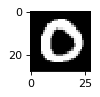

In [5]:
for i in range(5):
    image = np.array(X.iloc[i]).reshape(28,28)
    plt.figure(figsize=(1, 1), dpi=80)
    plt.imshow(image, interpolation='nearest',cmap='gray')
    plt.show()

## 2. Обработка данных

Делим входные и выходные данные на тестовую и на обучающую выборки в соотношении 20% и 80%. На обучающей модель будет обучаться, на тестовой будет происходить верификация. 

Так как данные для каждого пикселя изображения лежат в пределах от 0 до 255, для обезразмеривания делим входные данные X на 255.



In [6]:
X_train, X_test, Y_train, Y_test = train_test_split( np.array(X) / 255 , np.array(Y), test_size=0.2)

In [7]:
print(X_train.shape)
print(X_test.shape)

(33600, 784)
(8400, 784)


Получаем массивы размерности batch_size*784, где batch_size - размер выборки. Для обучения нейронной сети необходимо представить массив в формате batch_size, 28, 28, 1. Переформатируем обучающую и тестовую выборки.

In [8]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

print(X_train.shape)
print(X_test.shape)


(33600, 28, 28, 1)
(8400, 28, 28, 1)


In [9]:
print(Y_train.shape)
print(Y_test.shape)

Y_train=Y_train.reshape(Y_train.shape[0],1)
Y_test=Y_test.reshape(Y_test.shape[0],1)

print(Y_train.shape)
print(Y_test.shape)

(33600,)
(8400,)
(33600, 1)
(8400, 1)


## 3. Построение и обучение нейронной сети

Для обработки изображений часто используются конволюционные(сверточные) сети.

Для построения используется стек слоев Sequential библиотеки Keras на бэкенде Tensorflow. Она позволяет строить любые нейронные сети :

In [10]:
model = Sequential()

Следующий слой - слой свёртки (конволюции). Cвертка (изображения) — это просто поэлементное умножение двух матриц, за которым следует сумма.

В свертке(изображения) участвует матрица(изображения) и ядро свёртки

По сути, это ядро налагается поверх матрицы и по очереди слева направо и сверху  внизу применяет математическую операцию (т. е. свертку) к каждой (x, y)-координате исходной матрицы изображения. Слои свертки используются, чтобы помочь сети определить параметры, которые могут быть упущены при простом сведении изображения к его значениям в пикселях.

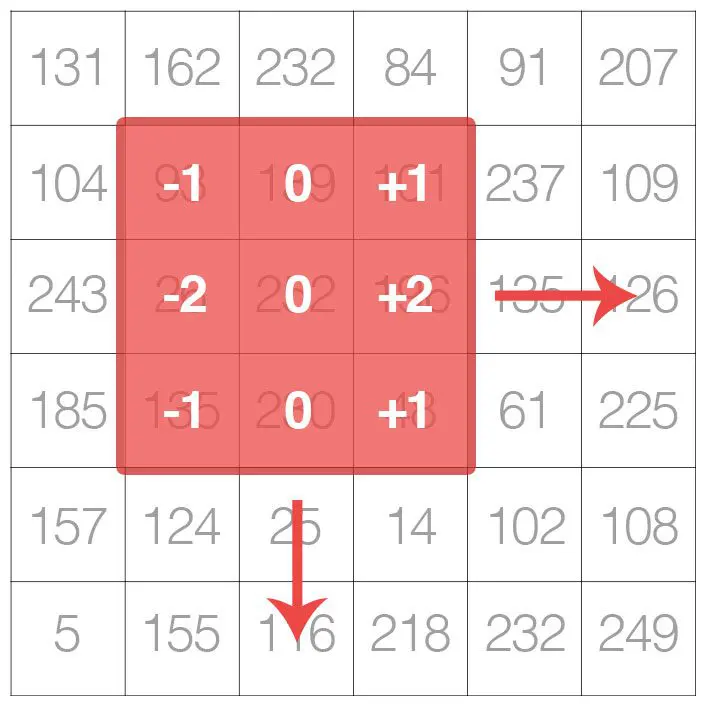

In [11]:
model.add(Conv2D(28, kernel_size=(3,3), input_shape=(28,28,1)))

Слой MaxPooling2D уменьшение объем данных за счет максимального объединения

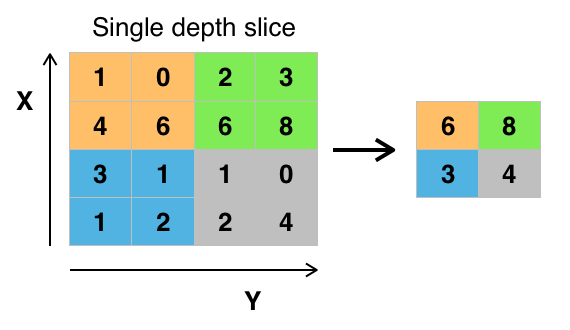

In [12]:
model.add(MaxPooling2D(pool_size=(2, 2)))

Слой Flatten выравнивает форму параметров(см далее)

In [13]:
model.add(Flatten()) 

Слой полносвязной нейронной сети c функцией активации ReLu:
    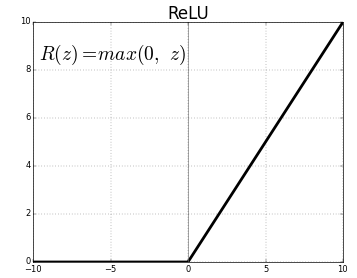

In [14]:
model.add(Dense(32, activation=tf.nn.relu))

Слой полносвязной нейронной сети c функцией активации Softmax:
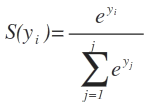

Число нейронов равно числу классов, которые есть в модели (в данном случае 10, от 0 до 9)

In [15]:
model.add(Dense(10,activation=tf.nn.softmax))

Компиляция сети с функцией оптимизации, функцией потерь и отражаемой метрикой. В данном случае в роли оптимизатора выступает Adam, функция потерь - категориальная кросс-энтропия, а метрикой будет являться точность (accuracy), то есть число правильно угаданных случаев в общему числу случаев

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4732)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                151456    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 152,066
Trainable params: 152,066
Non-trainable params: 0
_________________________________________________________________


История обучения:

In [18]:
history = model.fit(X_train, Y_train, epochs=20,validation_data=(X_test, Y_test), batch_size=4092, verbose=1)

Epoch 1/20
9/9 [==============================] - 32s 3s/step - loss: 2.0991 - accuracy: 0.3670 - val_loss: 1.4110 - val_accuracy: 0.6960
Epoch 2/20
9/9 [==============================] - 31s 3s/step - loss: 1.2376 - accuracy: 0.7377 - val_loss: 0.7645 - val_accuracy: 0.8206
Epoch 3/20
9/9 [==============================] - 30s 3s/step - loss: 0.6703 - accuracy: 0.8431 - val_loss: 0.4978 - val_accuracy: 0.8588
Epoch 4/20
9/9 [==============================] - 25s 3s/step - loss: 0.4565 - accuracy: 0.8714 - val_loss: 0.3995 - val_accuracy: 0.8805
Epoch 5/20
9/9 [==============================] - 25s 3s/step - loss: 0.3651 - accuracy: 0.8936 - val_loss: 0.3522 - val_accuracy: 0.8942
Epoch 6/20
9/9 [==============================] - 31s 4s/step - loss: 0.3333 - accuracy: 0.9030 - val_loss: 0.3209 - val_accuracy: 0.9035
Epoch 7/20
9/9 [==============================] - 41s 4s/step - loss: 0.3016 - accuracy: 0.9097 - val_loss: 0.3025 - val_accuracy: 0.9094
Epoch 8/20
9/9 [==================

Обучающая кривая нейронной сети:

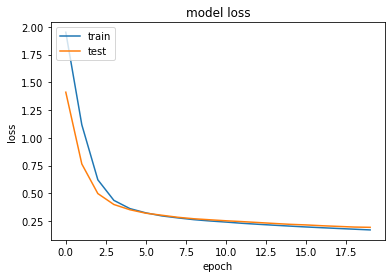

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4. Результаты

In [20]:
Y_predicted = model.predict(X_test)
pred_df = pd.DataFrame(Y_predicted)*100
pred_df[0:10]

,0,1,2,3,4,5,6,7,8,9
0,0.211,0.000,0.001,0.000,99.483,0.001,0.287,0.002,0.001,0.015
1,0.010,0.000,99.570,0.020,0.040,0.001,0.319,0.000,0.039,0.000
2,0.066,0.037,83.068,3.252,0.561,0.101,11.388,0.000,1.507,0.020
3,0.000,0.000,99.896,0.013,0.000,0.000,0.000,0.000,0.066,0.025
4,0.000,0.000,0.011,0.136,0.013,0.021,0.000,0.000,99.768,0.050
5,99.877,0.000,0.016,0.011,0.000,0.089,0.000,0.000,0.004,0.003
6,0.001,98.848,0.526,0.072,0.001,0.026,0.005,0.024,0.495,0.002
7,0.000,0.000,0.003,99.996,0.000,0.001,0.000,0.000,0.000,0.000
8,0.016,0.000,0.033,0.003,0.009,0.129,99.806,0.000,0.001,0.002
9,0.003,0.000,0.001,0.000,99.871,0.002,0.071,0.008,0.006,0.038


Истинный класс: 4
Предсказанный класс: 4


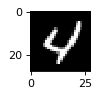

Истинный класс: 2
Предсказанный класс: 2


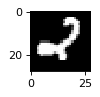

Истинный класс: 2
Предсказанный класс: 2


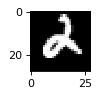

Истинный класс: 2
Предсказанный класс: 2


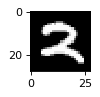

Истинный класс: 8
Предсказанный класс: 8


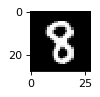

Истинный класс: 0
Предсказанный класс: 0


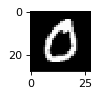

Истинный класс: 1
Предсказанный класс: 1


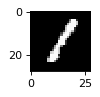

Истинный класс: 3
Предсказанный класс: 3


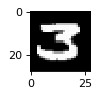

Истинный класс: 6
Предсказанный класс: 6


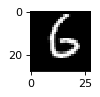

Истинный класс: 4
Предсказанный класс: 4


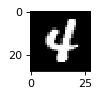

In [22]:
for i in range(10):
    print("Истинный класс:",Y_test[i][0])
    print("Предсказанный класс:",pred_df.iloc[i].idxmax(axis=1))
    image = np.array(X_test[i]).reshape(28,28)
    plt.figure(figsize=(1, 1), dpi=80)
    plt.imshow(image, interpolation='nearest',cmap='gray')
    plt.show()

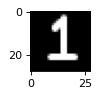

Истинный класс: 1
Предсказанный класс 1


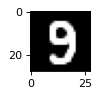

Истинный класс: 9
Предсказанный класс 3


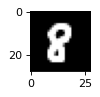

Истинный класс: 8
Предсказанный класс 8


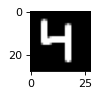

Истинный класс: 4
Предсказанный класс 4


In [127]:
array=[1,9,8,4]
for i in array:
    plt.figure(figsize=(1, 1), dpi=80)
    tmp = im.imread(f'Digit Recognizer/{i}.png')
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
    plt.imshow(tmp,cmap='gray')
    plt.show()
    tmp=tmp.reshape(1,28,28,1)
    pred_df_1 = pd.DataFrame(model.predict(tmp))
    print('Истинный класс:',i)
    print('Предсказанный класс',pred_df_1.iloc[0].idxmax(axis=1))
